In [761]:
import pandas as pd
import numpy as np

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_theme()

**Load Data**

In [762]:
df = pd.read_parquet('data/wine/wine_review.parquet.gzip')
print(df.shape)
df[['title', 'description', 'variety', 'points', 'country', 'taster_name']].head()

(100538, 15)


,title,description,variety,points,country,taster_name
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",White Blend,87,Italy,Kerin O’Keefe
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Portuguese Red,87,Portugal,Roger Voss
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,87,US,Paul Gregutt
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Riesling,87,US,Alexander Peartree
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Pinot Noir,87,US,Paul Gregutt


**Helper Functions**

In [763]:
# sort field by review count in descending order
top = lambda field: df.groupby(field).count()['title'].sort_values(ascending=False).index

**Paint a Single Variety Card**

In [764]:
def paint_row(fig, variety):
  gs = GridSpec(1,2, width_ratios=[1, 2]) # Text column is 1/3, chart is 2/3
  variety_reviews = df.query(f'variety == "{variety}"')

  # add text summary
  ax_text = fig.add_subplot(gs[0])
  ax_text.text(0.1, .7, variety, fontsize='x-large', fontname='Sathu')
  ax_text.text(0.125, 0.4, f'{variety_reviews.points.mean():.1f} average', fontsize='small', color='gray',fontname='Arial Unicode MS')
  ax_text.text(0.125, 0.2, f'{variety_reviews.points.count()/1000:.1f}k reviews', fontsize='small', color='gray', fontname='Arial Unicode MS')
  ax_text.axis('off')  # Hide axes for the text box

  # Plot histogram and density function
  ax_chart = fig.add_subplot(gs[1])
  sns.barplot(variety_reviews.points.value_counts().reset_index(),x='points',y='count',hue='count', palette='Purples', legend=False, ax=ax_chart, width=1)
  sns.despine()
  plt.axis('off')
  plt.show()


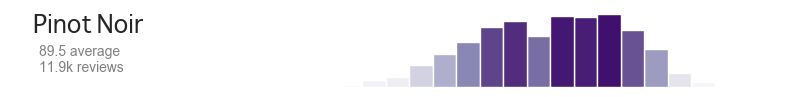

In [765]:
fig = plt.figure(figsize=(10, 1))
# Outer GridSpec (2x2)
paint_row(fig, 'Pinot Noir')

**Helper to Paint a Card per Value**

In [766]:
np.unique(df.points)

array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100])

In [767]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.pylab import setp

def reviews_by(field, values, x='points', orient='v'):
  fig, ax = plt.subplots(len(values),2, figsize=(6, 1*len(values)), sharex=True, gridspec_kw={'width_ratios':[1, 3]})

  # Create a list to hold the subplots
  axes = [ax[row][col] for row in range(len(values)) for col in range(2)]

  xaxis = sorted(np.unique(df[x]))

  for i, value in enumerate(values):
    # reviews for the value
    value_reviews = df.query(f'{field} == "{value}"')

    # add text elements
    ax_text = axes[i*2]
    ax_text.text(0.1, .65, value, fontsize='medium', fontname='Sathu')
    ax_text.text(0.125, 0.4, f'{value_reviews.points.mean():.1f} average', fontsize='x-small', color='gray',fontname='Arial Unicode MS')
    ax_text.text(0.125, 0.2, f'{value_reviews.points.count()/1000:.1f}k reviews', fontsize='x-small', color='gray', fontname='Arial Unicode MS')
    ax_text.axis('off')  # Hide axes for the text box
    
    # Plot histogram and density function
    ax_chart = axes[i*2 + 1]
    review_counts = value_reviews[x].value_counts(sort=True).reset_index()
    if orient == 'h':
      # show top 5 wines by reviewer
      sns.barplot(review_counts.iloc[:5,:],x='count', y=x, hue='count', palette='Purples', 
                  legend=False, ax=ax_chart, width=1, hue_norm=Normalize(0, review_counts['count'].max()))
      ax_chart.set_xticks([])
      ax_chart.set_xlabel(None)
      ax_chart.set_ylabel(None)
      ax_chart.set_xlim(0, 5000)
      ax_chart.set_yticks(review_counts.index[:5])
    else:
      # show distribution plot, like points, by wine variety
      X = pd.DataFrame(index=pd.Series(xaxis, name=x))
      X['count'] = 0
      X.loc[review_counts.set_index(x).index, 'count'] = review_counts.set_index(x)['count']
      # print(X)
      sns.barplot(X.reset_index(),x=x,y='count',hue='count', palette='Purples', 
                  legend=False, ax=ax_chart, width=1, orient=orient)
      ax_chart.set_yticks([])
      ax_chart.set_ylabel(None)
      # ax_chart.set_xticks(sorted(review_counts.set_index(x).sort_index().index.to_list()))
      ax_chart.set_facecolor('white')
    sns.despine(ax=ax_chart)
    
  if orient == 'v':
    # format the x axis in bottom chart
    idx = 2*len(values) - 1
    # axes[idx].set_axis_on()
    axes[idx].set_xlabel(None)
    # axes[idx].set_ylabel(None)
    # axes[idx].set_yticks([])
    # print(review_counts.set_index(x).sort_index().index)
    axes[idx].set_xticks(axes[idx].get_xticks())
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), fontsize='x-small')
  else:
    # format the wine varities in y-axis of all plots
    for i in range(len(values)):
      idx = 2*i+1
      axes[idx].set_yticklabels(axes[idx].get_yticklabels(), fontsize='x-small')

  plt.tight_layout()
  plt.show()

**Histogram of Reviews by Points for Varieties**

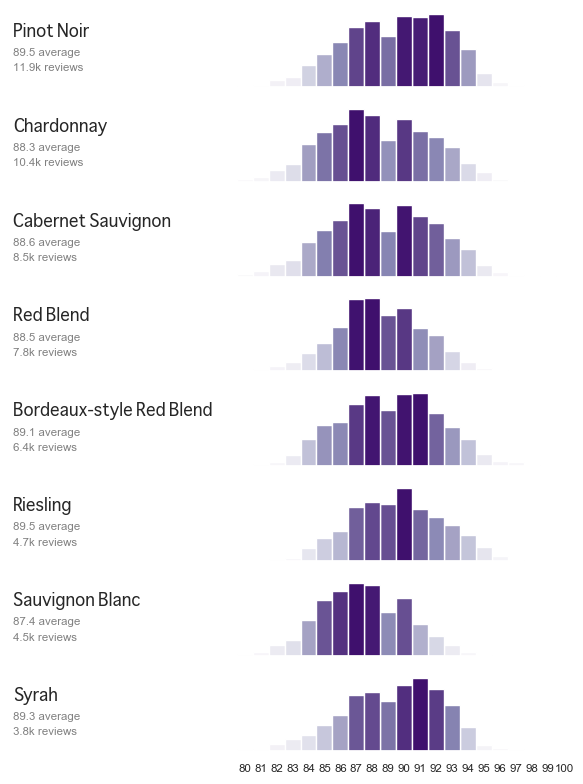

In [768]:
reviews_by('variety', top('variety')[:8])

**Histogram of Reviews by Points for Reviewers**

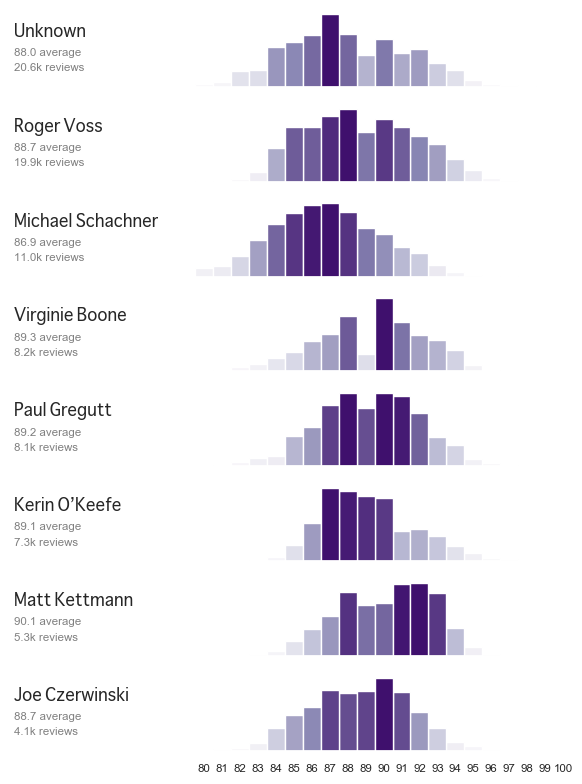

In [769]:
reviews_by('taster_name', top('taster_name')[:8])

**Histogram of Reviews by Variety for Reviewers**

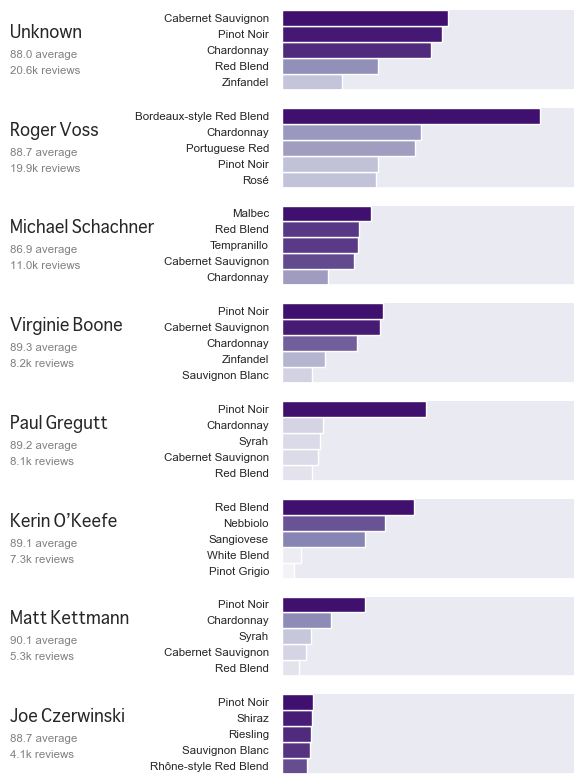

In [770]:
reviews_by('taster_name', top('taster_name')[:8], x='variety', orient='h')

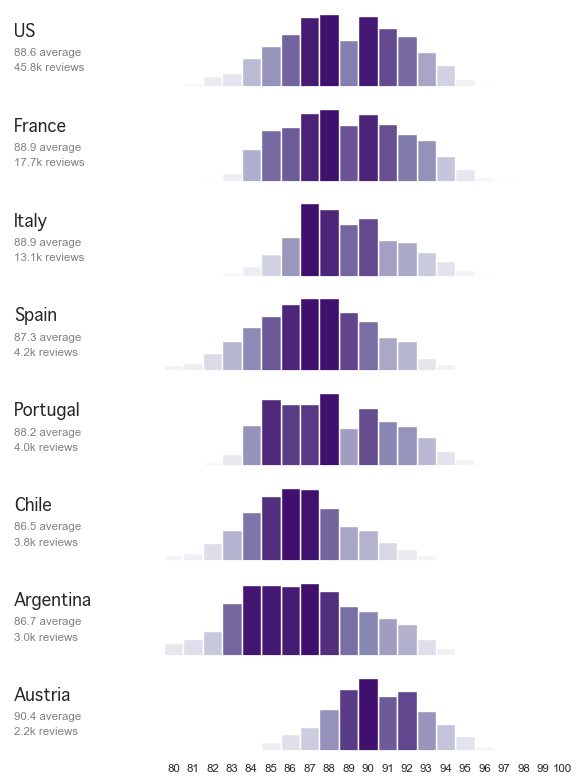

In [771]:
reviews_by('country', top('country')[:8])

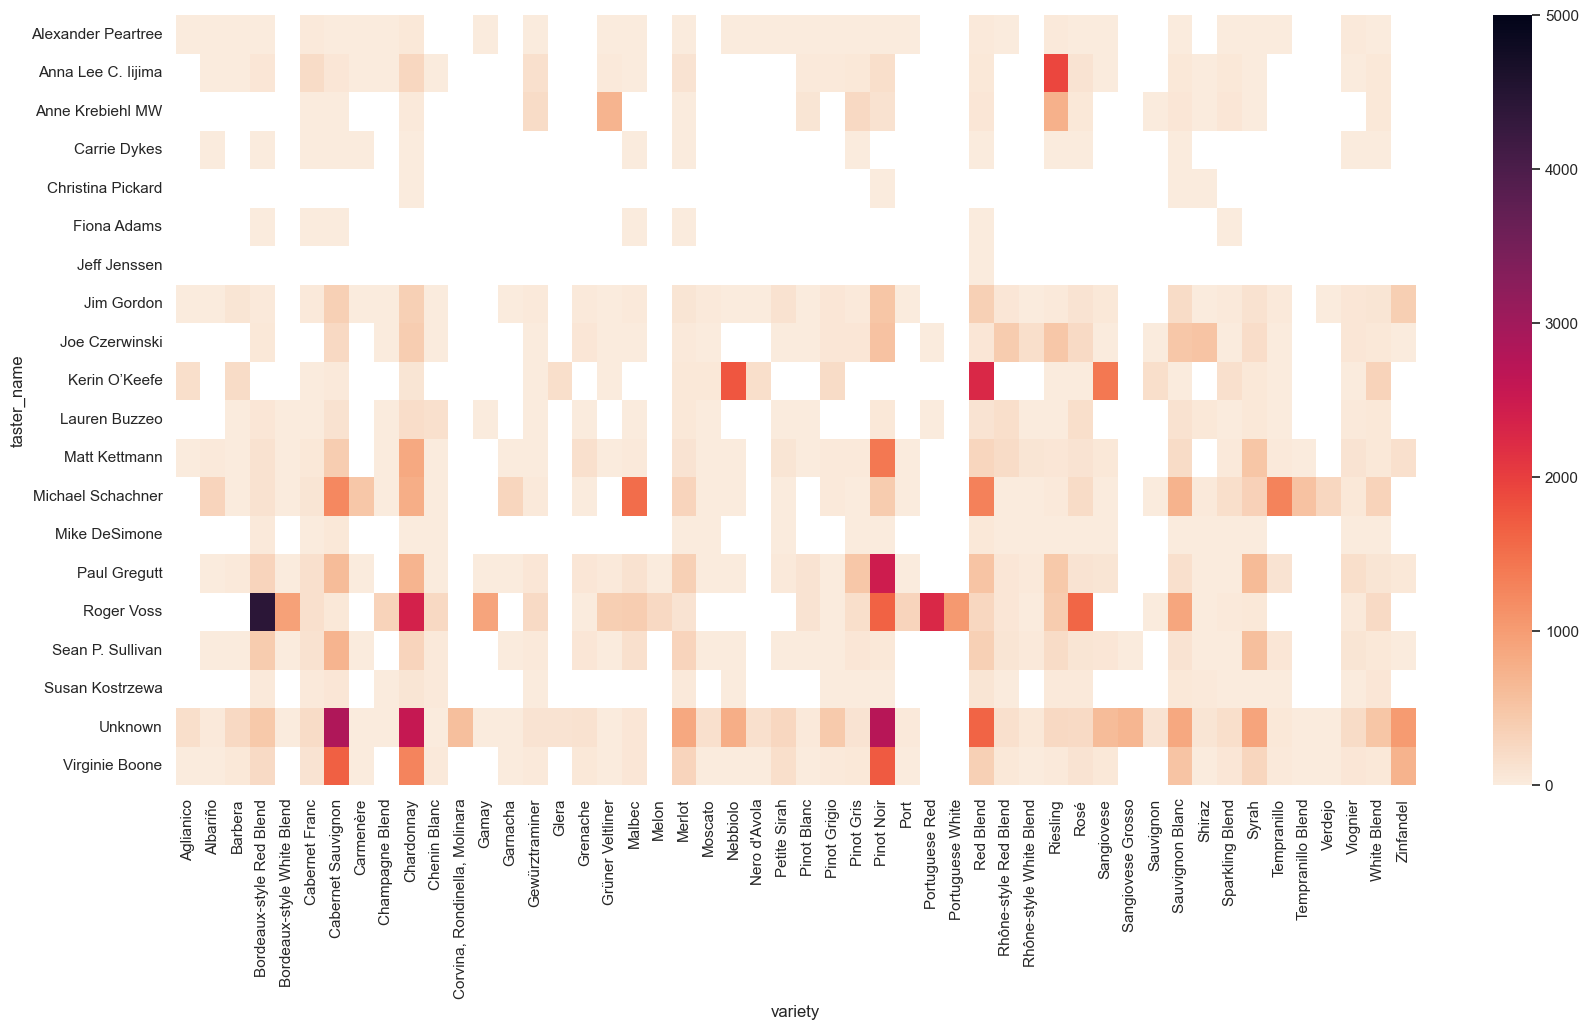

In [772]:
fig = plt.figure(figsize=(20, 10))
with sns.axes_style("white"):
  sns.heatmap(df.pivot_table(index='taster_name', columns='variety', values='title', aggfunc='count'),vmin=0, vmax=5000, cmap='rocket_r', robust=True)
plt.grid(False)

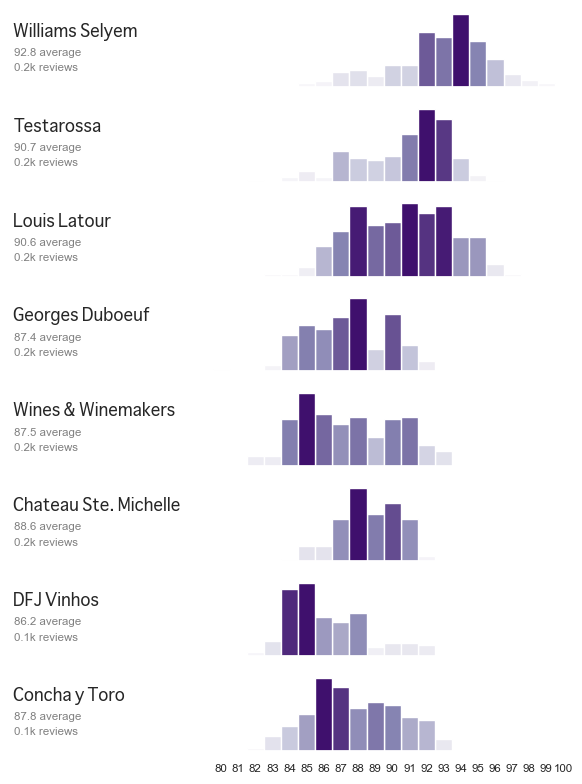

In [773]:
reviews_by('winery', top('winery')[:8])